### Importing necessary libraries

In [162]:
from datetime import datetime,timedelta
import time
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
import MetaTrader5 as mt5
import yfinance as yf
import mplfinance as mpf

In [163]:
# connect to metatrader5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
 
# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=3211, maxbars=100000, codepage=0, ping_last=165294, community_balance=0.0, retransmission=0.0, company='MetaQuotes Software Corp.', name='MetaTrader', language='English', path='C:\\Program Files\\MetaTrader4', ...)
(500, 3211, '14 Feb 2022')


In [64]:
# request 1000 ticks from EURAUD
euraud_ticks = mt5.copy_ticks_from("EURAUD", datetime(2021,1,28,13), 1000, mt5.COPY_TICKS_ALL)

In [65]:
# request ticks from AUDUSD within 2019.04.01 13:00 - 2019.04.02 13:00
audusd_ticks = mt5.copy_ticks_range("AUDUSD", datetime(2021,1,27,13), datetime(2021,1,28,13), mt5.COPY_TICKS_ALL)

In [66]:
# get bars from different symbols in a number of ways
#eurusd_rates = mt5.copy_rates_from("EURUSD", mt5.TIMEFRAME_M1, datetime(2021,1,28,13), 500)
#eurgbp_rates = mt5.copy_rates_from_pos("EURGBP", mt5.TIMEFRAME_M1, 0, 500)
eurcad_rates = mt5.copy_rates_range("EURCAD", mt5.TIMEFRAME_M5, datetime(2021,1,27), datetime(2021,2,27))

In [44]:
# shut down connection to MetaTrader 5
mt5.shutdown()

True

In [90]:
def get_data(symbol):
    now = datetime.now()
    start = datetime.now() - timedelta(days=30)
    utc_from = datetime(start.year, start.month, start.day)
    utc_to = datetime(now.year, now.month, now.day)
    rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_H1, utc_from, utc_to)
    print("Ticks received:",len(rates))
    htf = pd.DataFrame(rates)
    htf['time']=htf['time'].apply(lambda x: datetime.fromtimestamp(x))
    htf.set_index('time',inplace=True)
    return htf


In [97]:
oil_df=get_data('OILUSD')
usdcad_df=get_data('USDCAD')

Ticks received: 454
Ticks received: 481


In [104]:
new_df=pd.concat([oil_df['close'],usdcad_df['close']],axis=1).dropna()
new_df.columns=['oil close','usdcad close']
new_df

,oil close,usdcad close
time,,
2022-02-14 02:00:00,92.66,1.27234
2022-02-14 03:00:00,92.85,1.27286
2022-02-14 04:00:00,92.89,1.27397
2022-02-14 05:00:00,92.97,1.27413
2022-02-14 06:00:00,92.73,1.27339
...,...,...
2022-03-11 19:00:00,105.64,1.27223
2022-03-11 20:00:00,106.15,1.27303
2022-03-11 21:00:00,106.30,1.27136


<Mpf_Figure size 2000x500 with 0 Axes>

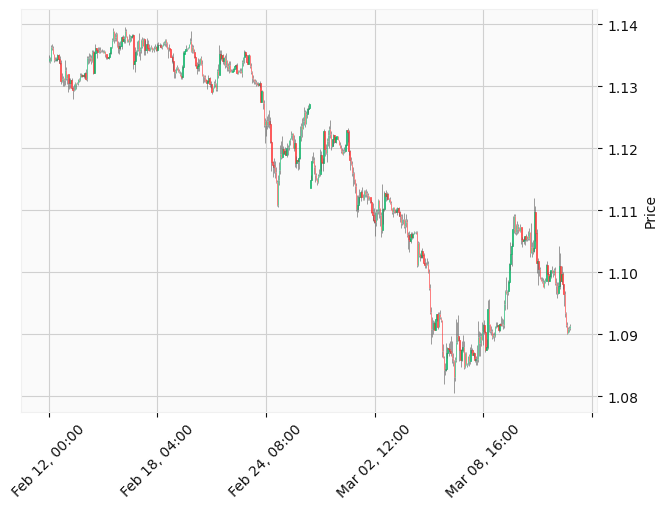

In [70]:
# plot from metatrader
mpf.figure(figsize=(20,5))
mpf.plot(htf,type='candle', style='yahoo')

In [132]:
## Using an alternative source of data to see variation
tick=yf.Ticker('EURUSD=X')
dfeu=tick.history(interval='1h',period='1mo')
dfeu.head()
dfeu.index=dfeu.index.tz_convert(None)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2022-02-10 23:00:00+00:00,1.142857,1.142857,1.141032,1.141813,0,0,0
2022-02-11 00:00:00+00:00,1.141553,1.141683,1.139082,1.140251,0,0,0
2022-02-11 01:00:00+00:00,1.140121,1.141162,1.139861,1.140641,0,0,0
2022-02-11 02:00:00+00:00,1.140641,1.141162,1.139991,1.140641,0,0,0
2022-02-11 03:00:00+00:00,1.140641,1.140901,1.139601,1.139731,0,0,0


<Mpf_Figure size 2000x500 with 0 Axes>

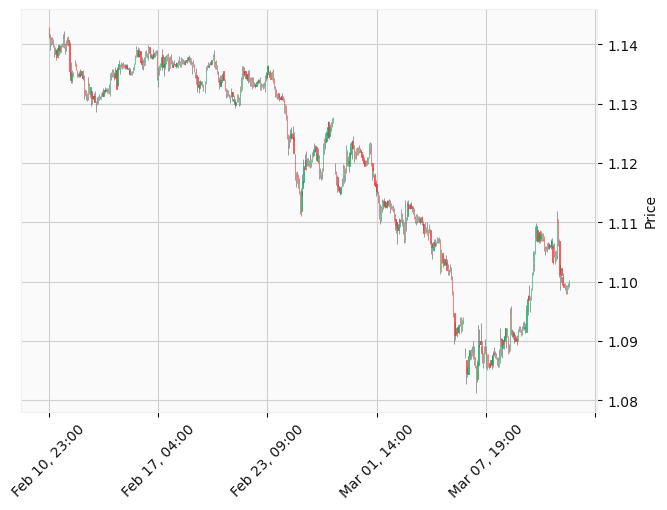

In [133]:
# this is a plot of eurusd for approx. 1 month 
mpf.figure(figsize=(20,5))
mpf.plot(dfeu,type='candle', style='yahoo')

In [161]:
corr_df=pd.concat([dfeu['Close'],htf['close']],axis=1)
corr_df=corr_df.rename(columns={'Close':'yf_close','close':'mt5_close'}).dropna()
corr_df.corr()

,yf_close,mt5_close
yf_close,1.000000,0.990533
mt5_close,0.990533,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

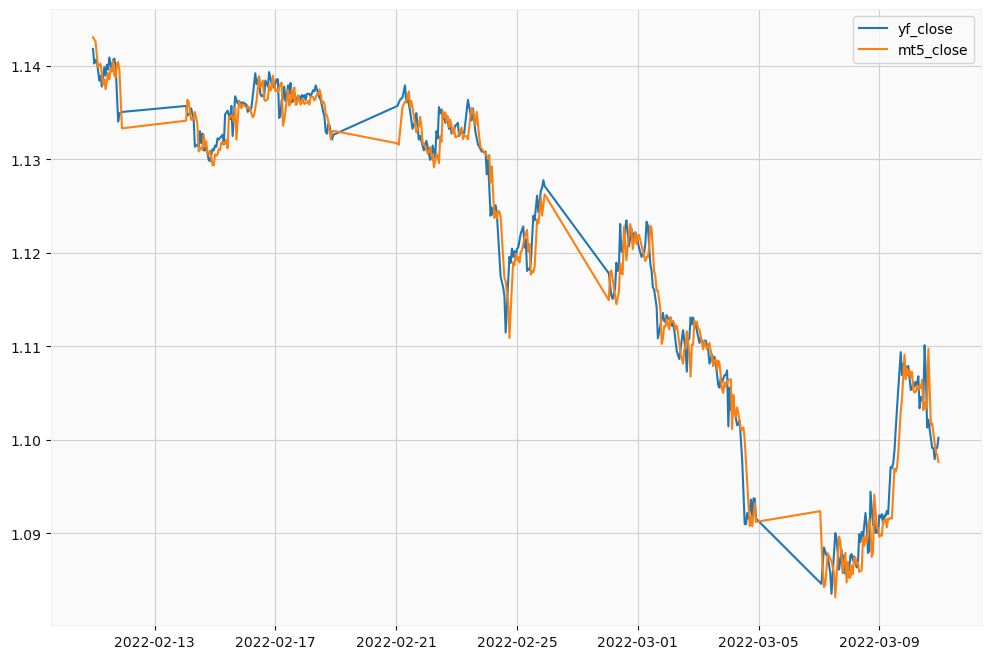

In [164]:
plt.figure(figsize=(12,8))
plt.plot(corr_df['yf_close'],label='yf_close')
plt.plot(corr_df['mt5_close'],label='mt5_close')
plt.legend()
plt.show

In [168]:
corr_df.pct_change(1).corr()

,yf_close,mt5_close
yf_close,1.000000,0.093798
mt5_close,0.093798,1.000000


In [169]:
corr_df2=corr_df.pct_change(1)

<function matplotlib.pyplot.show(close=None, block=None)>

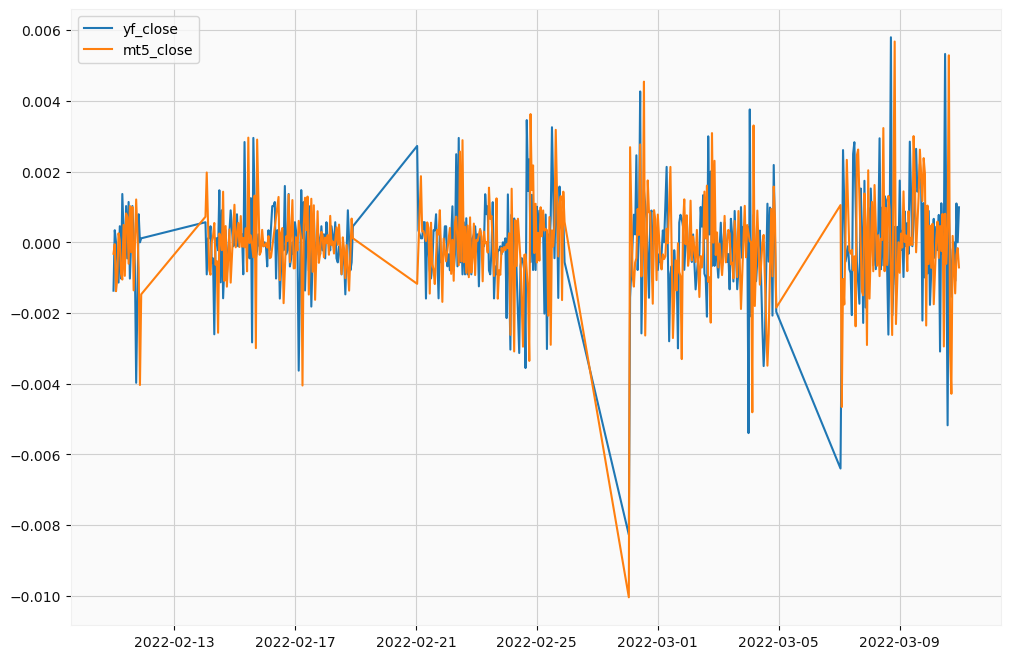

In [170]:
plt.figure(figsize=(12,8))
plt.plot(corr_df2['yf_close'],label='yf_close')
plt.plot(corr_df2['mt5_close'],label='mt5_close')
plt.legend()
plt.show

In [12]:
mt5.symbol_info('EURUSD')

SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1647027895, digits=5, spread=29, spread_float=True, ticks_bookdepth=32, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=1, trade_freeze_level=1, trade_exemode=2, swap_mode=3, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=15, filling_mode=3, order_mode=127, order_gtc_mode=0, ...)

In [89]:
mt5.symbol_info_tick('EURUSD')

Tick(time=1647273084, bid=1.0954, ask=1.09569, last=0.0, volume=0, time_msc=1647273084792, flags=4, volume_real=0.0)

In [154]:
symbol="EURUSD"
SL=40
TP=40
volume= 0.01
tick = mt5.symbol_info(symbol).point * 10
   
   # Define the request
request = {                     "action": mt5.TRADE_ACTION_DEAL,
                                "symbol": symbol,
                                "volume":volume,
                                "type": mt5.ORDER_TYPE_SELL,
                                "price": mt5.symbol_info_tick(symbol).bid,
                                "sl": mt5.symbol_info_tick(symbol).ask + SL * tick,
                                "tp": mt5.symbol_info_tick(symbol).ask - TP * tick,
                                "deviation": 10,
                                "magic": int(datetime.now().timestamp()),
                                "comment": "my algo buy",
                                "type_time": mt5.ORDER_TIME_GTC,
                                "type_filling": mt5.ORDER_FILLING_IOC,
                            }
                                
  # And with this line we send the request
result = mt5.order_send(request)
  # Visualize the result
print(result)

OrderSendResult(retcode=10009, deal=1004416897, order=1007802985, volume=0.01, price=1.09414, bid=1.09414, ask=1.09442, comment='Request executed', request_id=3, retcode_external=0, request=TradeRequest(action=1, magic=1647266331, order=0, symbol='EURUSD', volume=0.01, price=1.09414, stoplimit=0.0, sl=1.09842, tp=1.09042, deviation=10, type=1, type_filling=1, type_time=0, expiration=0, comment='my algo buy', position=0, position_by=0))


In [156]:
mt5.positions_get()

(TradePosition(ticket=1007802985, time=1647277131, time_msc=1647277131833, time_update=1647277131, time_update_msc=1647277131833, type=1, magic=1647266331, identifier=1007802985, reason=3, volume=0.01, price_open=1.09414, sl=1.09842, tp=1.09042, price_current=1.09511, swap=0.0, profit=-0.97, symbol='EURUSD', comment='my algo buy', external_id=''),)

In [157]:
## 
symbol='EURUSD'
request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": mt5.positions_get(symbol=symbol)[0].volume,
            "type": mt5.ORDER_TYPE_BUY, 
            "position": mt5.positions_get(symbol=symbol)[0].identifier,
            "price": mt5.symbol_info_tick(symbol).ask,
            "deviation": 10,
            "magic": int(datetime.now().timestamp()),
            "comment": "close trade",
            "type_time": mt5.ORDER_TIME_GTC}
                                
  # And with this line we send the request
result = mt5.order_send(request)